In [3]:
import os
import random
import zipfile
from io import BytesIO
from zipfile import ZipFile

import albumentations as A
import cv2
import mglyph as mg
import torch
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import ImageReadMode

import mglyph_ml.lib as lib
from mglyph_ml.image_provider import GlyphProvider
from mglyph_ml.manifest_parsing import Manifest

# Building the training set

In [2]:
def square(x: float, canvas: mg.Canvas):
    canvas.tr.scale(mg.lerp(x, 0.2, 0.95))
    canvas.rect(canvas.top_left, canvas.bottom_right, color="red")


lib.export_glyph(square, name="square", glyph_set="1")

IntProgress(value=0, description='Exporting square 1.0.0:', max=1000, style=ProgressStyle(bar_color='cornflowe…

KeyboardInterrupt: 

In [ ]:
# here, we need to load the glyph and convert it into a format that'll be accepted by the NN
glyph_location: str = "data/glyphs-1/square.mglyph"
glyph_provider: GlyphProvider = GlyphProvider(glyph_location)


In [ ]:
from torch import Tensor
import torchvision.transforms.functional as TF

# Creating the PyTorch Dataset and DataLoader
import albumentations as A
import numpy as np
from io import BytesIO
from PIL import Image as PILImage
import torch
import os
import cv2

class ImageDataset(Dataset):
    def __init__(self, zip_path: str, min_label: float | None = None, max_label: float | None = None, augment: bool = False, normalize: bool = True):
        self.zip_path = zip_path
        # Do not use global archive; always open as needed
        with zipfile.ZipFile(self.zip_path, 'r') as zf:
            manifest = zf.read("metadata.json")
        self.manifest = Manifest.model_validate_json(manifest)
        # Use raw labels (0-100) for splitting
        samples = [(sample.filename, sample.x) for sample in self.manifest.images]
        if min_label is not None:
            samples = [s for s in samples if s[1] >= min_label]
        if max_label is not None:
            samples = [s for s in samples if s[1] < max_label]
        self.samples = samples
        self.archive = None
        self.augment = augment
        self.normalize = normalize
        # Normalization parameters (ImageNet defaults) - applied after converting to [0,1] floats
        self.mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
        self.std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
        if augment:
            # Use small translate_percent (±5%) and constant white padding to avoid black fill from translations/rotations
            # Use OpenCV border_mode and 'value' for fill color (uint8).
            self.transform = A.Compose([
                A.Affine(rotate=(-5, 5),
                         translate_percent=(-0.20, 0.20),
                         fit_output=False,
                         keep_ratio=True,
                         border_mode=cv2.BORDER_CONSTANT,
                         fill=255
                         ),
            ])
        else:
            self.transform = None

    def _ensure_archive(self):
        if self.archive is None:
            self.archive = zipfile.ZipFile(self.zip_path, 'r')

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> tuple[Tensor, float]:
        self._ensure_archive()
        filename, label = self.samples[index]
        img_bytes = self.archive.read(filename)
        # Use PIL to decode reliably and get an HWC uint8 numpy array
        img_pil = PILImage.open(BytesIO(img_bytes))
        # If image has alpha channel, paste onto white background
        if img_pil.mode in ('RGBA', 'LA') or (img_pil.mode == 'P' and 'transparency' in img_pil.info):
            background = PILImage.new('RGBA', img_pil.size, (255, 255, 255, 255))
            background.paste(img_pil, mask=img_pil.split()[-1])
            img_pil = background.convert('RGB')
        else:
            img_pil = img_pil.convert('RGB')
        img_np = np.array(img_pil)  # H x W x C, dtype=uint8, values 0-255
        # Apply augmentation on HWC uint8 image
        if self.augment and self.transform is not None:
            augmented = self.transform(image=img_np)
            img_np = augmented['image']
        # Convert to CHW float tensor in [0,1] for the model
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0
        # Optionally normalize to zero-mean/unit-std using mean/std (channels first)
        if self.normalize:
            img_tensor = (img_tensor - self.mean[:, None, None]) / self.std[:, None, None]
        label = label / 100.0
        return img_tensor, label

# Configure DataLoader workers and create datasets/loaders
recommended_workers = min(4, os.cpu_count() or 1)
train_set_1 = ImageDataset(zip_path=glyph_location, max_label=80, augment=True, normalize=True)
train_loader_1 = torch.utils.data.DataLoader(train_set_1, shuffle=True, batch_size=8, num_workers=recommended_workers, pin_memory=True)
test_set_1 = ImageDataset(zip_path=glyph_location, min_label=80, augment=False, normalize=True)

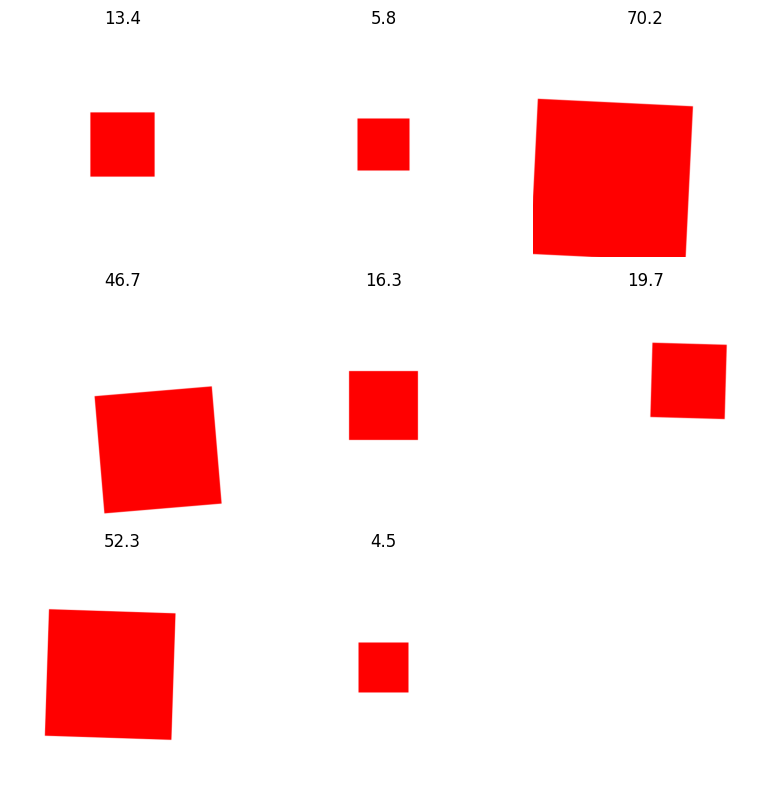

In [ ]:
# Helpers: un-normalize tensors and visualize a batch from a DataLoader
import math

def unnormalize_tensor_to_uint8(img_tensor: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> np.ndarray:
    """Convert a CHW torch tensor that was normalized (with mean/std) back to HWC uint8 for display.
    img_tensor: (C, H, W) in normalized float format
    returns H x W x C uint8 numpy array"""
    # move to cpu and clone to avoid modifying original
    img = img_tensor.detach().cpu().clone()
    if img.ndim == 4:
        # take first element if batch provided
        img = img[0]
    # unnormalize: img = img * std + mean
    img = img * std[:, None, None] + mean[:, None, None]
    img = torch.clamp(img, 0.0, 1.0)
    img_np = (img.permute(1, 2, 0).numpy() * 255.0).round().astype(np.uint8)
    return img_np

def show_batch_from_loader(loader: DataLoader, n: int = 9, mean: torch.Tensor = None, std: torch.Tensor = None):
    """Grab one batch from loader and show up to n images (handles normalized tensors)."""
    batch = next(iter(loader))
    imgs, labels = batch
    # default mean/std (should match dataset)
    if mean is None or std is None:
        mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
        std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    count = min(n, imgs.shape[0])
    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)
    fig = plt.figure(figsize=(8, 8))
    for i in range(count):
        img_vis = unnormalize_tensor_to_uint8(imgs[i], mean, std)
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img_vis)
        ax.set_title(f"{labels[i].item() * 100:.1f}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Demo: show a batch from the training loader (if available)
try:
    show_batch_from_loader(train_loader_1, n=9, mean=train_set_1.mean, std=train_set_1.std)
except Exception as e:
    print('Unable to show batch automatically:', e)

In [ ]:
# Quick dataset sanity checks: show shapes and value ranges for a few samples
for i in range(3):
    idx = random.randint(0, len(train_set_1) - 1)
    img, label = train_set_1[idx]
    print(f"sample {i}: idx={idx}, shape={tuple(img.shape)}, dtype={img.dtype}, min={img.min().item():.6f}, max={img.max().item():.6f}, label={label:.3f}")

# Also show counts and recommended DataLoader workers setting
total = len(train_set_1)
recommended_workers = min(4, os.cpu_count() or 1)
print(f"train samples: {total}, recommended num_workers={recommended_workers}")

sample 0: idx=235, shape=(3, 512, 512), dtype=torch.float32, min=-2.035714, max=2.640000, label=0.235
sample 1: idx=717, shape=(3, 512, 512), dtype=torch.float32, min=-2.035714, max=2.640000, label=0.717
sample 2: idx=62, shape=(3, 512, 512), dtype=torch.float32, min=-2.035714, max=2.640000, label=0.062
train samples: 800, recommended num_workers=4


Now that we've imported the zip file and parsed the manifest, we can build our NN

In [ ]:
class GlyphRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: (batch, 3, 512, 512)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # (3,512,512) -> (16,512,512)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # (16,512,512) -> (16,256,256)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # (16,256,256) -> (32,256,256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (32,256,256) -> (32,128,128)
        # Reduce spatial size before FC to lower memory: adaptive pool to 8x8
        self.adaptivepool = nn.AdaptiveAvgPool2d((8, 8))  # (32,128,128) -> (32,8,8)
        # Flatten: 32*8*8 = 2048 (much smaller than 32*128*128)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.adaptivepool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train(train_data_loader: DataLoader[ImageDataset]) -> GlyphRegressor:
    model = GlyphRegressor()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1):
        running_loss = 0.0
        for i, data in enumerate(train_data_loader, 0):
            inputs, labels = data
            labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 20 == 19:
                avg_loss = running_loss / 20
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                running_loss = 0.0  # Reset after printing

    print('Finished Training')
    return model

In [ ]:
# After training, evaluate 10 random samples from the test set:
model = train(train_loader_1)
model.eval()
with torch.no_grad():
    # Generate 10 random indices from the test set
    random_indices = torch.randint(0, len(test_set_1), size=(10,)).tolist()
    for idx in random_indices:
        img, true_label = test_set_1[idx]
        # add batch dimension: (C,H,W) -> (1,C,H,W)
        img_batch = img.unsqueeze(0)
        pred = model(img_batch).item()
        print(f"True: {true_label * 100:.1f}, Predicted: {pred * 100:.1f}")
    print("=====train set======")
    random_indices = torch.randint(0, len(train_set_1), size=(10,)).tolist()
    for idx in random_indices:
        img, true_label = train_set_1[idx]
        # add batch dimension: (C,H,W) -> (1,C,H,W)
        img_batch = img.unsqueeze(0)
        pred = model(img_batch).item()
        print(f"True: {true_label * 100:.1f}, Predicted: {pred * 100:.1f}")


BadZipFile: Caught BadZipFile in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/djsushi/School/BAK/mglyph-ml/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/djsushi/School/BAK/mglyph-ml/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_223425/3261872834.py", line 58, in __getitem__
    img_bytes = self.archive.read(filename)
  File "/usr/lib/python3.13/zipfile/__init__.py", line 1602, in read
    with self.open(name, "r", pwd) as fp:
         ~~~~~~~~~^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.13/zipfile/__init__.py", line 1660, in open
    raise BadZipFile("Bad magic number for file header")
zipfile.BadZipFile: Bad magic number for file header
